<a href="https://colab.research.google.com/github/akashdhanpal/Pnemonia_Detection_CV_Deep_Learning/blob/main/Capstone_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set the current working directory

%cd /content/drive/My Drive/Capstone/

/content/drive/My Drive/Capstone


In [3]:
# Prerequisites - Unzip files and install pydicom

# unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [2]:
#Install pydicom to read the DCM images
!pip install pydicom

In [3]:
# Import all required libraries
import pandas as pd
import numpy as np
import pylab
from skimage.transform import resize
import pathlib
import glob, pylab, pandas as pd
import pydicom as dicom
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.applications.densenet import DenseNet121
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.applications import VGG19
from keras.layers import Dropout,Flatten

In [4]:
labels = pd.read_csv('/content/drive/My Drive/Capstone/stage_2_train_labels.csv')

In [5]:
print(labels.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


In [8]:
# read a single patient dicom image file to check its header and metadata

patientId = labels['patientId'][0]
dcm_file = '/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % patientId
dcm_data = dicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [9]:
# Accessing underlying pixel data

im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

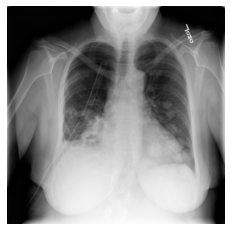

In [10]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

#**Basic EDA**

In [6]:
import gc
import warnings
warnings.simplefilter(action = 'ignore')

In [7]:
# Load the data

class_info = pd.read_csv('/content/drive/My Drive/Capstone/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Capstone/stage_2_train_labels.csv')

data = pd.merge(left = class_info, right = train_labels, how = 'left', on = 'patientId')

del class_info, train_labels
gc.collect()

data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  37629 non-null  object 
 1   class      37629 non-null  object 
 2   x          16957 non-null  float64
 3   y          16957 non-null  float64
 4   width      16957 non-null  float64
 5   height     16957 non-null  float64
 6   Target     37629 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


In [8]:
data.head(10)

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
6,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
7,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
8,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0


In [9]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [10]:
data.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


Rows per patient ID

In [11]:
data['patientId'].value_counts().head()

0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
Name: patientId, dtype: int64

In [12]:
# checking a single patient ID

data[data['patientId'] == '0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d']

,patientId,class,x,y,width,height,Target
36153,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,654.0,444.0,160.0,103.0,1
36154,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,531.0,206.0,289.0,213.0,1
36155,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,686.0,545.0,128.0,106.0,1
36156,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,213.0,386.0,114.0,161.0,1


In [13]:
# Total number of patients

data['patientId'].count()


30227

In [14]:
# Patients having Pneumonia

data[data['Target'] == 1]['patientId'].count()

9555

In [15]:
# Each of patients without pneumonia has only one row in dataset

data[data['Target'] == 0]['patientId'].count()

20672

#Plots to check the distribution of data

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

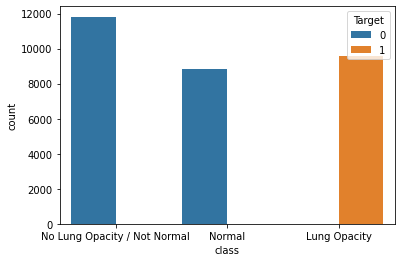

In [22]:
sns.countplot(x = 'class', hue = 'Target', data=data);

In [23]:
data['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

This means that only the class "Lung Opacity" are the patients having Pneumonia in the dataset and they have a "Target" set as 1 against them

The other two classes(No Lung Opacity / Not Normal, Normal) have a "Target" set as 0 against them which means they do not have Pneumonia

In [24]:
# Checking few statistics of bounding box coordinates

area = data.dropna()[['x', 'y', 'width', 'height']].copy()

In [25]:
area.head()

,x,y,width,height
4,264.0,152.0,213.0,379.0
5,562.0,152.0,256.0,453.0
10,323.0,577.0,160.0,104.0
11,695.0,575.0,162.0,137.0
18,288.0,322.0,94.0,135.0


In [26]:
area.describe()

,x,y,width,height
count,9555.000000,9555.000000,9555.000000,9555.000000
mean,394.047724,366.839560,218.471376,329.269702
std,204.574172,148.940488,59.289475,157.750755
min,2.000000,2.000000,40.000000,45.000000
25%,207.000000,249.000000,177.000000,203.000000
50%,324.000000,365.000000,217.000000,298.000000
75%,594.000000,478.500000,259.000000,438.000000
max,835.000000,881.000000,528.000000,942.000000


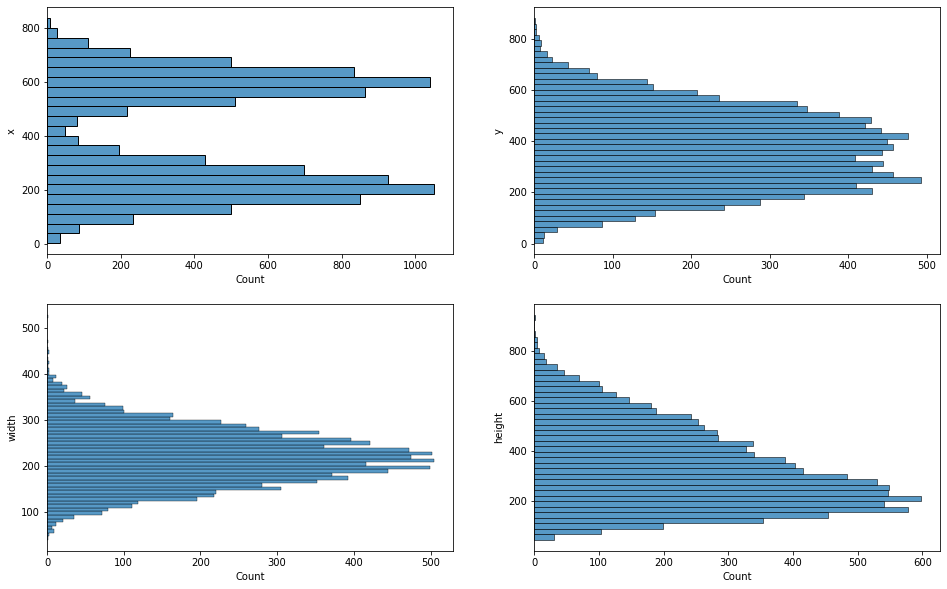

In [27]:
n_columns = 2
n_rows = 2
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(area.columns):
    sns.histplot(y = c, data = area, ax = axes[i // n_columns, i % n_columns])
#plt.tight_layout()
plt.show()

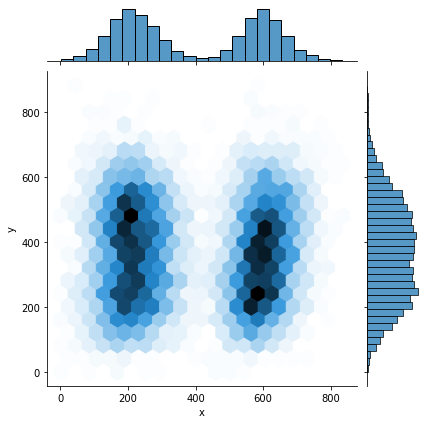

In [28]:
# jointplot

sns.jointplot(x = 'x', y = 'y', data = area, kind = 'hex', gridsize = 20);

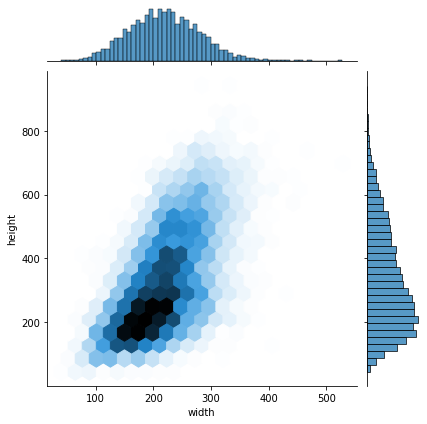

In [29]:
sns.jointplot(x = 'width', y = 'height', data = area, kind = 'hex', gridsize = 20);

Above plot shows that width and height have very tight correlation

# Analysis of meta information

In [16]:
data_meta = data.drop('class', axis=1).copy()

In [17]:
data_meta.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [23]:
from  tqdm import tqdm

In [46]:
patientId = data_meta['patientId'].drop_duplicates().values
pat = patientId[:26684]
patient_info = pd.DataFrame()

for p in tqdm(pat):
    ds = dicom.dcmread('/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % p, stop_before_pixels=True, defer_size='10 KB', specific_tags=[(0x0010, 0x1010), (0x0010, 0x0040), (0x0010, 0x0020), (0x0018, 0x5101)])
    tmp_info = pd.DataFrame({
        'patientId': [ds.PatientID],
        'age': [ds.PatientAge],
        'sex': [ds.PatientSex],
        'viewPosition': [ds.ViewPosition]
    })
    patient_info = patient_info.append(tmp_info)


# for p in pat:
#   dcm_file = '/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % p
#   dcm_data = dicom.dcmread(dcm_file, stop_before_pixels=True, specific_tags=[(0x0010, 0x1010), (0x0010, 0x0040), (0x0010, 0x0020), (0x0018, 0x5101)])
#   print(dcm_data)

100%|██████████| 26684/26684 [4:35:13<00:00,  1.62it/s]


In [47]:
patient_info.to_csv('/content/drive/My Drive/Capstone/patient_info.csv')

In [18]:
patient_data = pd.read_csv('../Capstone/patient_info.csv', usecols=['patientId', 'age', 'sex', 'viewPosition'])

In [19]:
data_merged = pd.merge(data, patient_data, on='patientId')

In [20]:
data_merged.head()

,patientId,class,x,y,width,height,Target,age,sex,viewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,51,F,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,48,F,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,19,M,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,28,M,PA
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,32,F,AP


In [21]:
data_merged.shape

(30227, 10)

In [22]:
data_unique = data_merged.drop_duplicates('patientId', keep='first')

In [23]:
data_unique.shape

(26684, 10)

# Patient Age vs Target


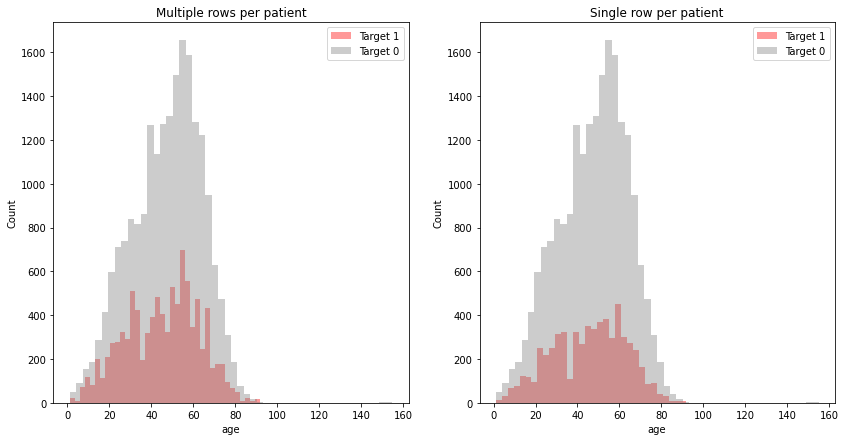

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(data_merged[data_merged['Target']==1]['age'], hist=True, kde=False, color='red', label='Target 1', ax=axes[0])
p = sns.distplot(data_merged[data_merged['Target']==0]['age'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Multiple rows per patient')

p = sns.distplot(data_unique[data_unique['Target']==1]['age'], hist=True, kde=False, color='red', label='Target 1', ax=axes[1])
p = sns.distplot(data_unique[data_unique['Target']==0]['age'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

# Patient Age vs Class

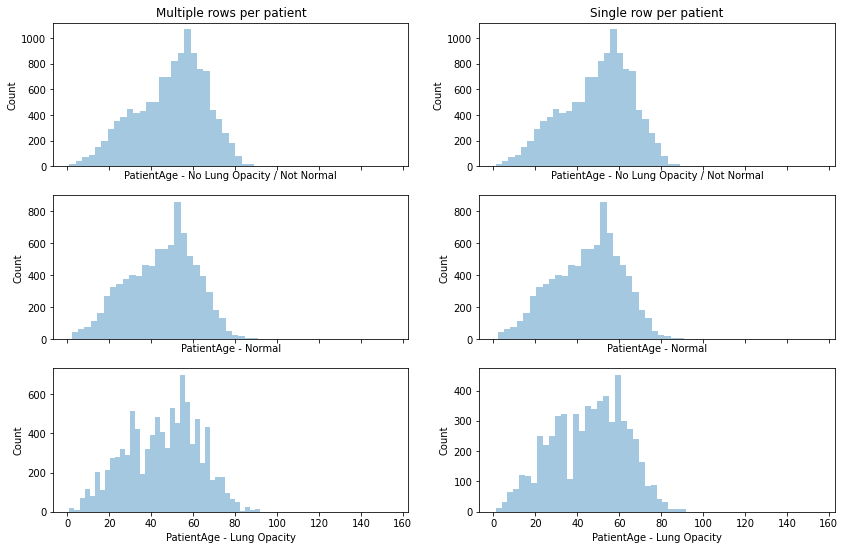

In [73]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)
for i, _class in enumerate(data_merged['class'].dropna().unique()):
    p = sns.distplot(data_merged[data_merged['class']==_class]['age'], hist=True, kde=False, ax=axes[i, 0])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Multiple rows per patient')
    
    p = sns.distplot(data_unique[data_unique['class']==_class]['age'], hist=True, kde=False, ax=axes[i, 1])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Single row per patient')

# Patient Sex vs Target

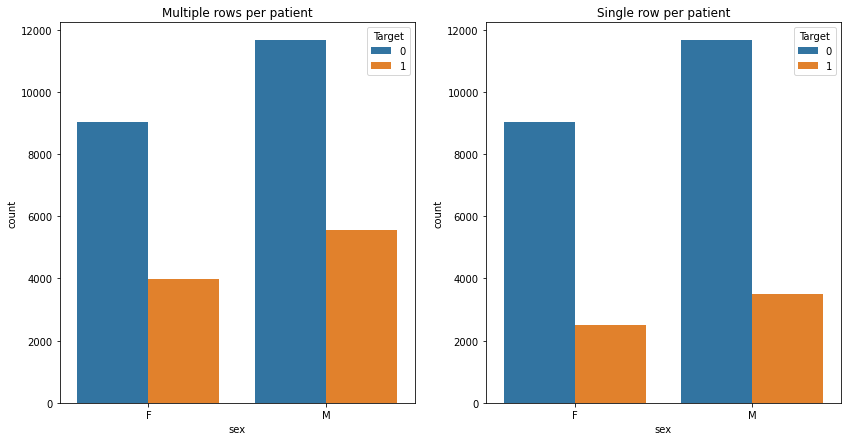

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='sex', hue='Target', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='sex', hue='Target', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

#Patient Sex vs Class

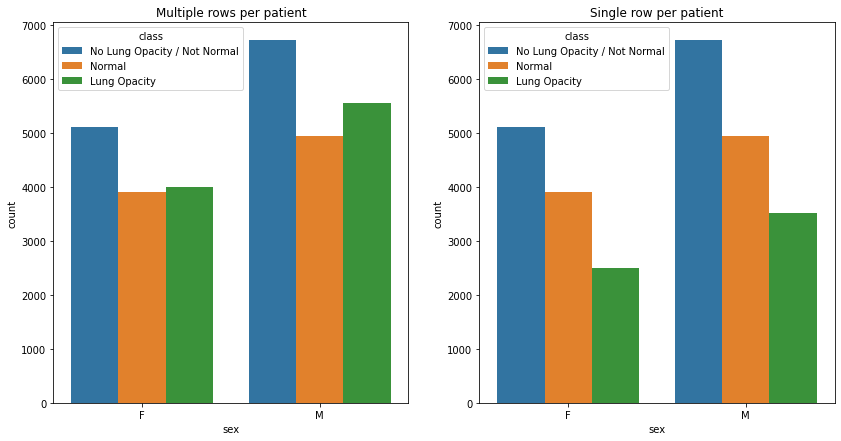

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='sex', hue='class', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='sex', hue='class', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient Age & Sex vs Target

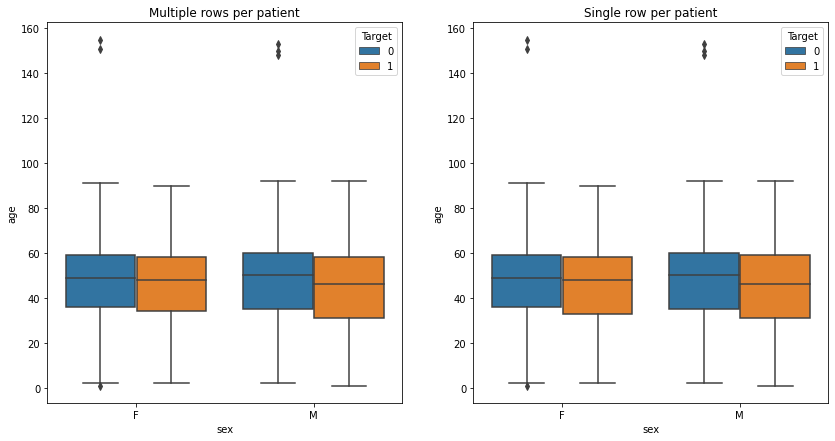

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='sex', y='age', hue='Target', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.boxplot(x='sex', y='age', hue='Target', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient Age & Sex vs Class

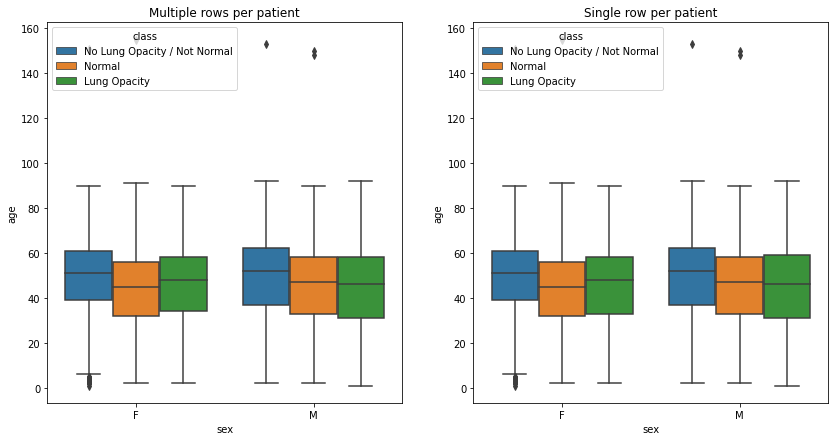

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='sex', y='age', hue='class', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.boxplot(x='sex', y='age', hue='class', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient Age vs ViewPosition

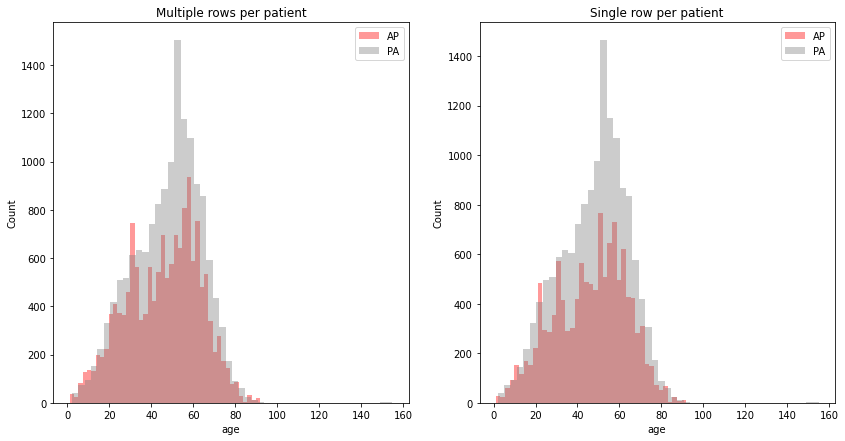

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(data_merged[data_merged['viewPosition']=='AP']['age'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(data_merged[data_merged['viewPosition']=='PA']['age'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Multiple rows per patient')

p = sns.distplot(data_unique[data_unique['viewPosition']=='AP']['age'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(data_unique[data_unique['viewPosition']=='PA']['age'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

# Patient ViewPosition vs Sex

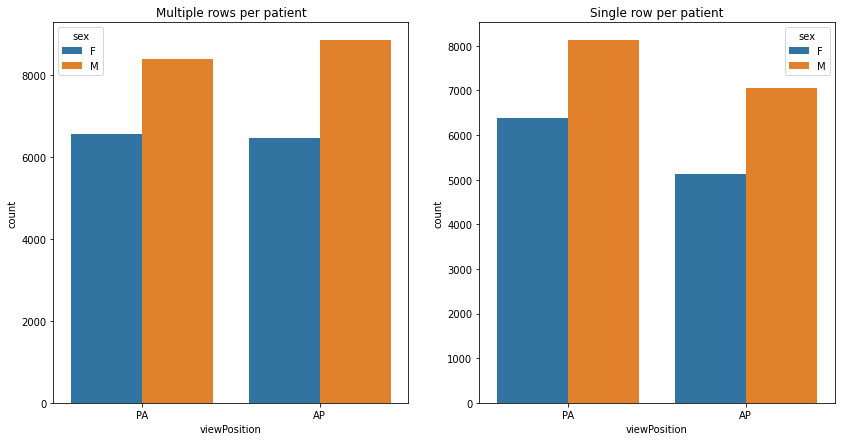

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='viewPosition', hue='sex', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='viewPosition', hue='sex', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient ViewPosition vs Target

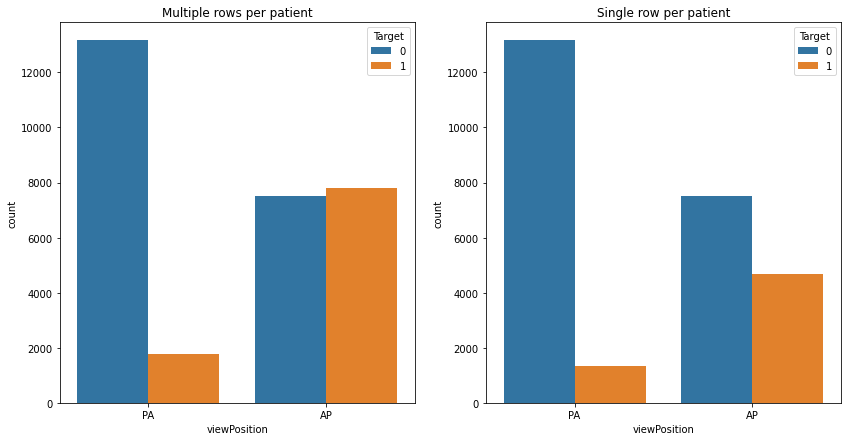

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='viewPosition', hue='Target', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='viewPosition', hue='Target', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient ViewPosition vs Class

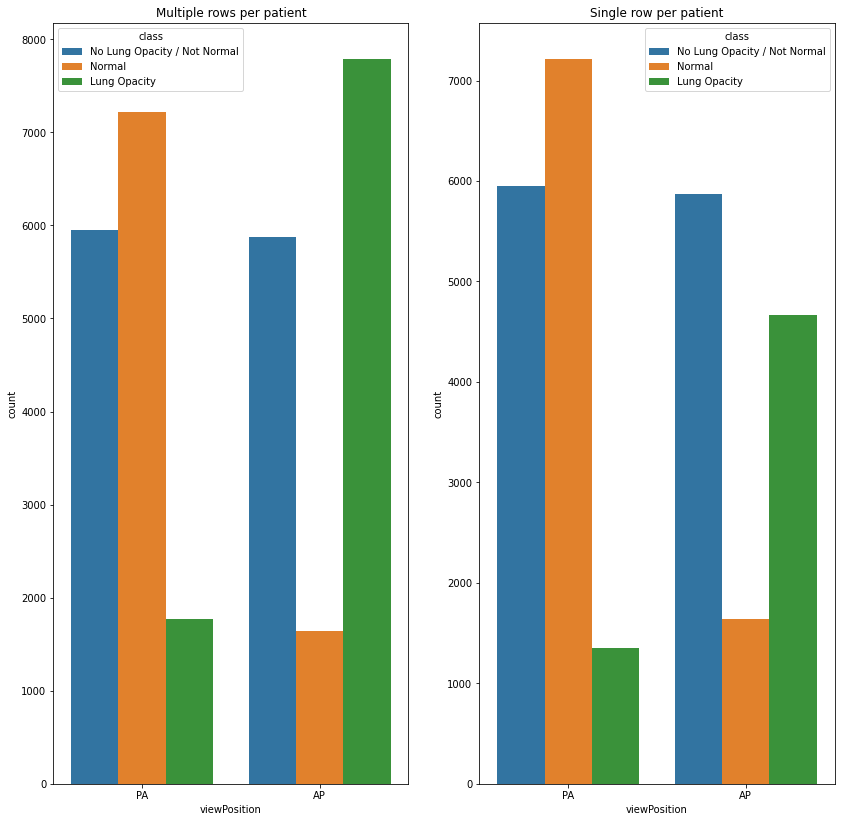

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
p = sns.countplot(x='viewPosition', hue='class', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='viewPosition', hue='class', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Displaying train images with bounding box for pneumonia patients


In [48]:
train_images_dir = '/content/drive/My Drive/Capstone/stage_2_train_images/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]

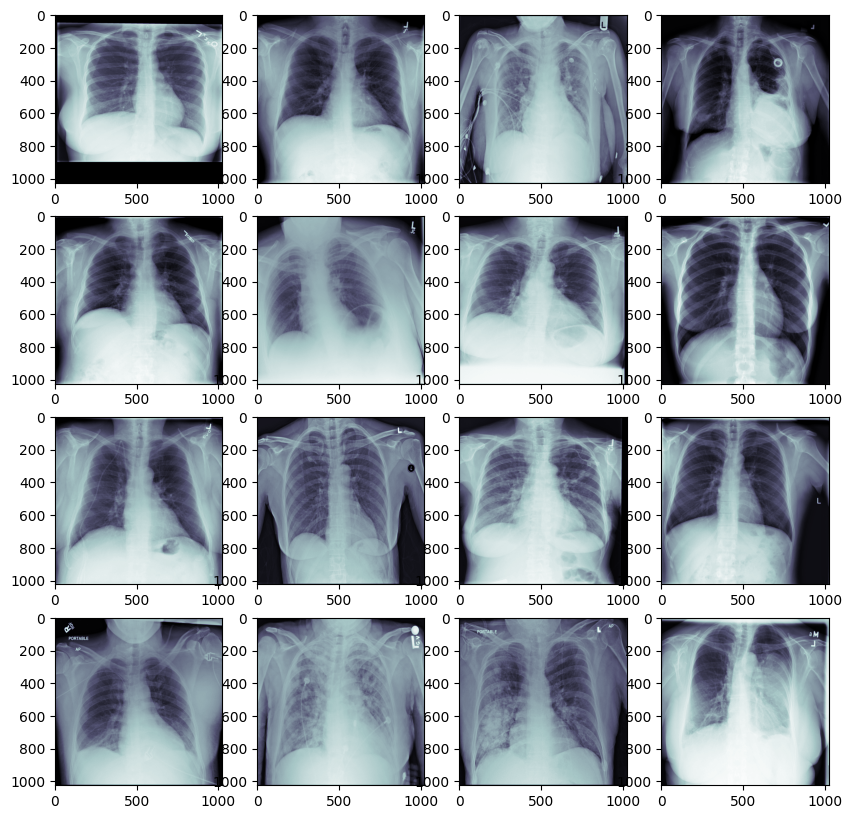

In [51]:
#Plotting a few train images
plt.style.use('default')
fig=plt.figure(figsize=(10, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    ds = dicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [52]:
#Converting csv into data dictionary so as to get the path of dicom file, target and bounding box coordinate for a patient id all into one structure
def parse_data(df):
  extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

  parsed = {}
  for n, row in df.iterrows():
  #Initialize patient entry into parsed 
      pid = row['patientId']
      if pid not in parsed:
          parsed[pid] = {
                'dicom': '/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

#Add box if opacity is present
      if parsed[pid]['label'] == 1:
          parsed[pid]['boxes'].append(extract_box(row))
  return parsed

In [53]:
#Using the parse_data function for our data and checking one entry
parsed = parse_data(data)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '/content/drive/My Drive/Capstone/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [54]:
#Function to draw single patient bounding box on the image

def draw(df):
    #Open DICOM file
    d = dicom.read_file(df['dicom'])
    im = d.pixel_array

    #Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    #Add boxes with red color if present
    for box in df['boxes']:
        rgb = [255, 0, 0]
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

#Function to get a coloured boundary box in the image
def overlay_box(im, box, rgb, stroke=1):
    #Convert coordinates to integers
    box = [int(b) for b in box]
    
    #Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

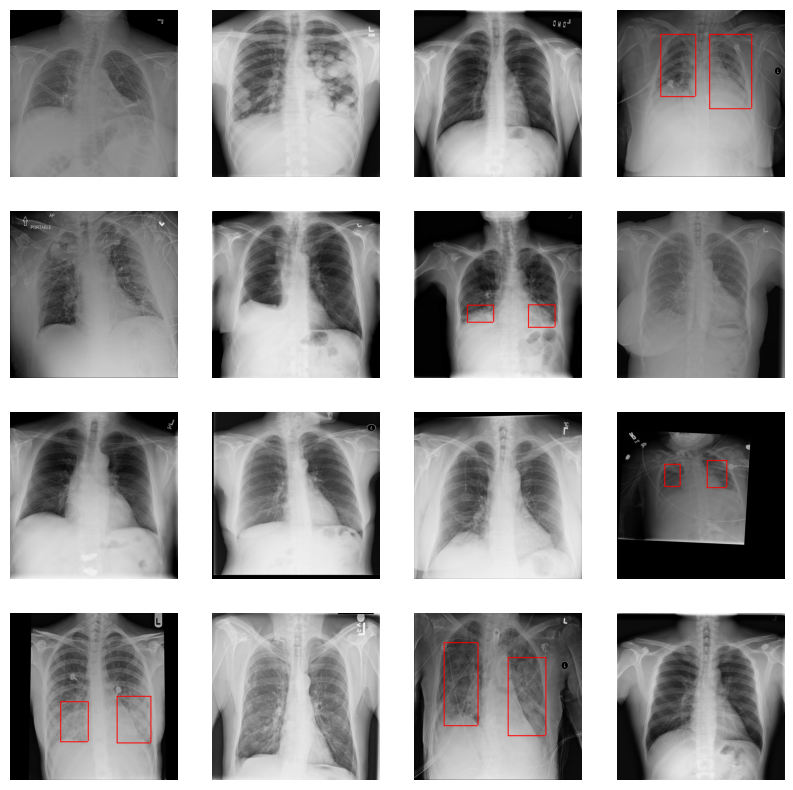

In [55]:
#Looking at images with boxes plotted
plt.style.use('default')
fig=plt.figure(figsize=(10, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[data['patientId'].unique()[i]])
    fig.add_subplot

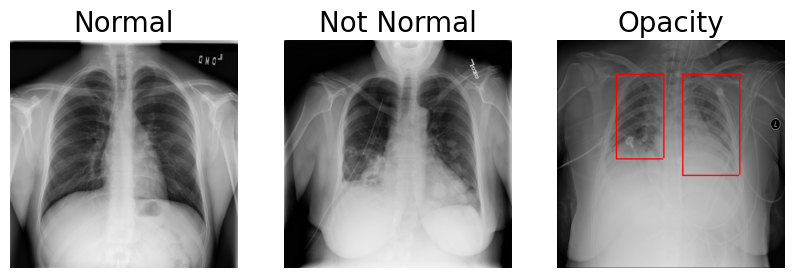

In [57]:
#Comapring the 3 classses : Opacity, Normal and Not Normal
opacity = data \
    .loc[data['class'] == 'Lung Opacity'] \
    .reset_index()
not_normal = data \
    .loc[data['class'] == 'No Lung Opacity / Not Normal'] \
    .reset_index()
normal = data \
    .loc[data['class'] == 'Normal'] \
    .reset_index()

fig=plt.figure(figsize=(10, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=20)
draw(parsed[normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=20)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=20)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[0]])

# Pre-processing data for model

In [24]:
# Set the paths for data files

train_images = '/content/drive/MyDrive/Capstone/stage_2_train_images/'
base = '/content/drive/MyDrive/Capstone/'

In [25]:
# Read the training CSV File and remove duplicates on Patient Id

filepath = (base+'/stage_2_train_labels.csv')
images = pd.read_csv(filepath)
train_labels = images[['patientId','Target']]
train_labels=train_labels.drop_duplicates(subset='patientId')

In [26]:
# number of unique labels
train_labels.shape

(26684, 2)

In [27]:
# Sample the training images for initial experimentation
train_labels = train_labels.sample(frac=1.0,random_state=7)

In [28]:
def train_test_dict(train_labels,test_size,random_state=7): 
   # Split into train and test validation datasets
    train_df, test_df = train_test_split(train_labels, test_size=0.02, random_state=7, stratify=train_labels[['Target']])
    
   # Convert to dictionary with patient-id as key and target as value
    train_dict=train_df.set_index('patientId')['Target'].to_dict()
    test_dict=test_df.set_index('patientId')['Target'].to_dict()
    return [train_dict,test_dict]

In [29]:
train_dict,test_dict = train_test_dict(train_labels,0.05)

In [30]:
print('Size of train set :',len(train_dict))
print('Size of test set :',len(test_dict))

Size of train set : 26150
Size of test set : 534


In [44]:
# Define Custom Generator Class to be used in Model Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, path,batch_size=128, dim=(224,224), n_channels=3,
                 n_classes=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path = path
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dcm_file_sample = (self.path +"/"+ ID +".dcm")
            dcm_data_sample = dicom.filereader.dcmread(dcm_file_sample)
            image = dcm_data_sample.pixel_array
            image_array = np.stack([image] * 3, axis=2)
            image_array = image_array / 255.
            image_array = resize(image_array, (224, 224), mode= 'constant', anti_aliasing=True)
            X[i,] = image_array

            # Store class
            y[i] = self.labels[ID]

        return X,y

# Model 1 : VGGNet

In [45]:
# Define the VGG19 model pre-loaded with imagenet weights with last layer set as false
input_shape = (224, 224, 3)
num_of_class=1
img_in = Input(input_shape)              
model = VGG19(include_top= False, 
                weights = '/content/drive/MyDrive/Capstone/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',  
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

# The pre-trained model has classification output for 14 categories and hence Dense layer is defined with layer 1
x = model.output  
predictions = Dense(1, activation="sigmoid", name="predictions")(x)    
model = Model(inputs=img_in, outputs=predictions)

In [46]:
# Print the model summary
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [47]:
# Create Train and Test generator
train_generator = DataGenerator(list(train_dict.keys()), train_dict,path=train_images,batch_size=32)
validation_generator = DataGenerator(list(test_dict.keys()), test_dict,path=train_images,batch_size=1)

In [48]:
#Define Custom Metrics Functions to be used in Keras Training
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
#Set Early stopping parameter and Reduce Learning rate on Plateau
callbacks_list = [EarlyStopping(monitor='val_loss',patience=5),
                  ModelCheckpoint(filepath=base+'vgg_model1.h5',monitor='val_loss',save_best_only=True),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2)]

In [50]:
# Set only the last layer as Trainable
def model_train_layers(model,layer_name):
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        
        if layer.name == layer_name:
            set_trainable = True
            #print(layer.name)
        if set_trainable:
             layer.trainable = True
        else:
             layer.trainable = False

In [51]:
model_train_layers(model,"predictions")

In [52]:
# Compile with binary cross entropy loss
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
# Run Fit Generator
history=model.fit(train_generator,
                    epochs=3,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

Epoch 1/3
 21/817 [..............................] - ETA: 6:08:08 - loss: 0.5809 - acc: 0.7351 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00